In [14]:
library(ggplot2)
library(dplyr)
library(readr)
library(tidyr)
library(lmPerm)

In [3]:
df <- read_csv('data/diabetes_012_health_indicators_BRFSS2015.csv')
head(df)

Rows: 253680 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,⋯,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,1,1,40,1,0,0,0,0,⋯,1,0,5,18,15,1,0,9,4,3
0,0,0,0,25,1,0,0,1,0,⋯,0,1,3,0,0,0,0,7,6,1
0,1,1,1,28,0,0,0,0,1,⋯,1,1,5,30,30,1,0,9,4,8
0,1,0,1,27,0,0,0,1,1,⋯,1,0,2,0,0,0,0,11,3,6
0,1,1,1,24,0,0,0,1,1,⋯,1,0,2,3,0,0,0,11,5,4
0,1,1,1,25,1,0,0,1,1,⋯,1,0,2,0,2,0,1,10,6,8


### Xử lí outliers

gom nhóm nhãn hiếm cho Education.       
1: Less than high school.       
2: High School.     
3: College.     
4: College gradute. 

In [10]:
df <- df %>%
  mutate(Education = case_when(
    Education %in% c(1,2,3) ~ 1,
    Education %in% c(4,5,6) ~ Education
  )) %>%
  mutate(Education = factor(Education, levels = c(1,4,5,6), labels = c(1,2,3,4)))

# change the type of the variable in Education to double
df$Education <- as.double(as.character(df$Education))

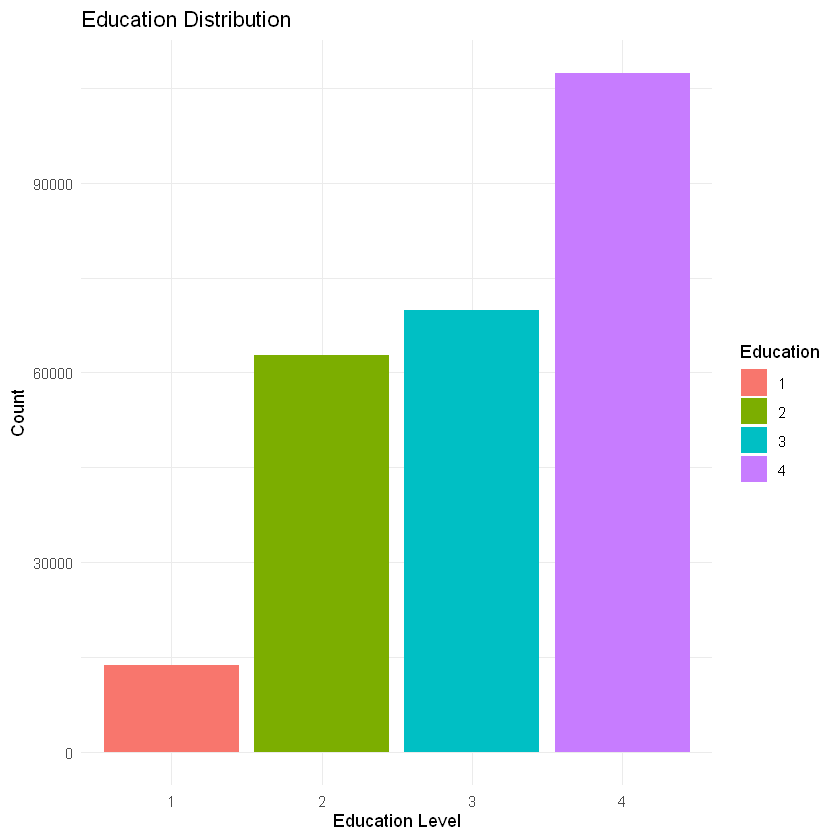

In [14]:
ggplot(df, aes(x=Education, fill=Education)) +
    geom_bar() +
    labs(title = "Education Distribution",
             x = "Education Level",
             y = "Count") +
    theme_minimal()

In [15]:
robust_scaler <- function(x) {
  Q1 <- quantile(x, 0.25) 
  Q3 <- quantile(x, 0.75) 
  IQR <- Q3 - Q1          
  median_x <- median(x)   

  scaled_x <- (x - median_x) / IQR
  return(scaled_x)
}

df <- df %>%
  mutate(BMI = robust_scaler(BMI)) %>%
  mutate(PhysHlth = robust_scaler(PhysHlth)) %>%
  mutate(MentHlth = robust_scaler(MentHlth))

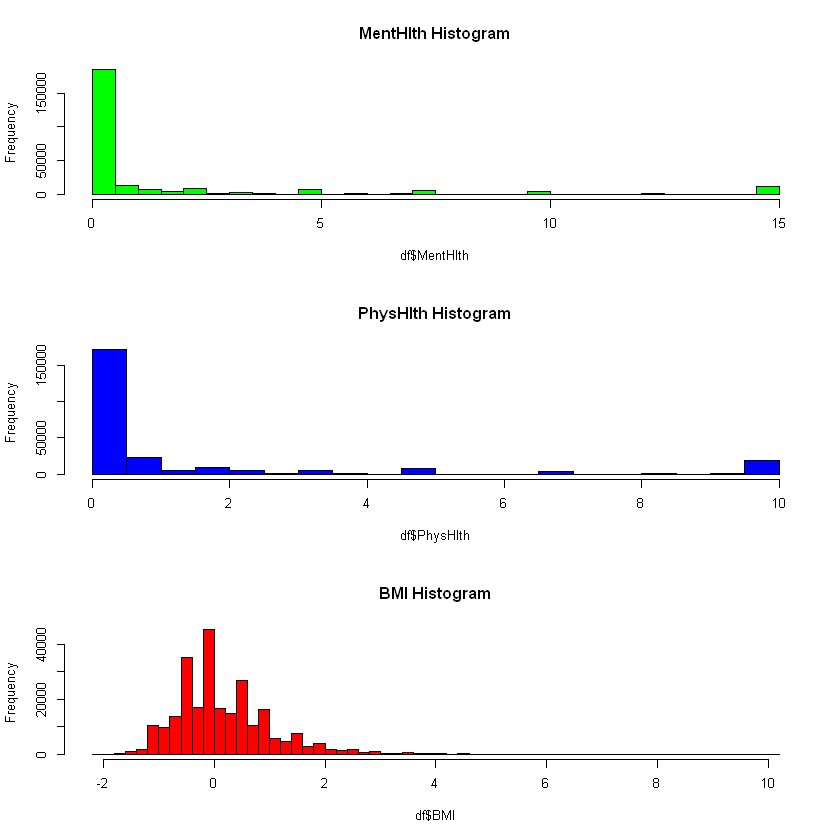

In [16]:
# plot the distribution of BMI, PhysHlth, and MentHlth
par(mfrow=c(3,1), bg='white')
hist(df$MentHlth, breaks=31, col='green', main='MentHlth Histogram')
hist(df$PhysHlth, breaks=31, col='blue', main='PhysHlth Histogram')
hist(df$BMI, breaks=84, col='red', main='BMI Histogram')

In [22]:
# save df to csv named 'clean_outliers.csv'
write.csv(df, 'data/clean_outliers.csv', row.names=FALSE)

### Kiểm định

In [3]:
df <- read_csv('data/clean_outliers.csv')

Rows: 253680 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
df <- df %>% distinct()
sum(duplicated(df))

[1] 0

In [6]:
# kiểm định chi-square với monte carlo simulation
chisq_test <- function(df, var1, var2) {
  observed <- table(df[[var1]], df[[var2]])
  chisq <- chisq.test(observed, simulate.p.value = TRUE, B = 5000)
  return(chisq)
}

In [8]:
# kiểm định kruskal-wallis
kruskal_test <- function(df, var1, var2) {
  kruskal <- kruskal.test(df[[var1]] ~ df[[var2]], data = df)
  return(kruskal)
}

#### Biến giải thích với predictor

In [13]:
vars <- c('HighBP', 'HighChol', 'CholCheck', 'Stroke', 'HeartDiseaseorAttack', 
        'PhysActivity', 'DiffWalk', 'GenHlth', 'Age', 'Education', 'Income')

chi_square_results <- data.frame(variable = character(), p_value = numeric(), reject = logical(), stringsAsFactors = FALSE)

for (var in vars) {
    chi_square <- chisq_test(df, 'Diabetes_012', var)
    reject <- chi_square$p.value < 0.05
    chi_square_results <- rbind(chi_square_results, data.frame(variable = var, p_value = chi_square$p.value, reject = reject))
}

chi_square_results


variable,p_value,reject
<chr>,<dbl>,<lgl>
HighBP,0.00019996,TRUE
HighChol,0.00019996,TRUE
CholCheck,0.00019996,TRUE
Stroke,0.00019996,TRUE
HeartDiseaseorAttack,0.00019996,TRUE
PhysActivity,0.00019996,TRUE
DiffWalk,0.00019996,TRUE
GenHlth,0.00019996,TRUE
Age,0.00019996,TRUE


In [11]:
chisq_test(df, 'Diabetes_012', 'AnyHealthcare')


	Pearson's Chi-squared test

data:  observed
X-squared = 146.18, df = 2, p-value < 2.2e-16


In [35]:
vars_quanlity <- c('BMI', 'PhysHlth', 'MentHlth')

for (var in vars_quanlity) {
   results <- aov(formula=df[[var]] ~ df[['Diabetes_012']], data = df)
   print(summary(results))
}


                         Df Sum Sq Mean Sq F value Pr(>F)    
df[["Diabetes_012"]]      1   9709    9709   10816 <2e-16 ***
Residuals            229769 206254       1                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
                         Df  Sum Sq Mean Sq F value Pr(>F)    
df[["Diabetes_012"]]      1   53820   53820    6075 <2e-16 ***
Residuals            229769 2035632       9                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
                         Df  Sum Sq Mean Sq F value Pr(>F)    
df[["Diabetes_012"]]      1   11380   11380   767.6 <2e-16 ***
Residuals            229769 3406656      15                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [39]:
for (var in vars_quanlity) {
   results <- kruskal_test(df, var, 'Diabetes_012')
   print(results)
}


	Kruskal-Wallis rank sum test

data:  df[[var1]] by df[[var2]]
Kruskal-Wallis chi-squared = 11827, df = 2, p-value < 2.2e-16


	Kruskal-Wallis rank sum test

data:  df[[var1]] by df[[var2]]
Kruskal-Wallis chi-squared = 4574.4, df = 2, p-value < 2.2e-16


	Kruskal-Wallis rank sum test

data:  df[[var1]] by df[[var2]]
Kruskal-Wallis chi-squared = 125.54, df = 2, p-value < 2.2e-16



#### Biến giải thích với nhau